In [92]:
import warnings
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [94]:
def wrangle(filepath):
    df = pd.read_csv(filepath,sep=';', encoding='latin-1')
    df["timestamp"]=df["timestamp"].str.replace("|" ," ")
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index("timestamp", inplace=True)
    # Localize timezone
    
    df.index=df.index.tz_localize('UTC').tz_convert('Africa/Nairobi')
    # remove outliers
    df=df[df['P2']<500]
    # Resample to 1hr window
    y = df["P2"].resample("1H").mean().fillna(method='ffill')
    return y
    

In [95]:
# import data 
df=wrangle("D:/KHALED/PortfolioProjects/projects/3- Air quality in Nairobi/data/nairobi-air-quality.csv")
assert df.index.tzinfo == pytz.timezone("Africa/Nairobi")
print(df.shape)
df.head()

(2928,)


C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\3678917617.py:3: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



timestamp
2018-09-01 03:00:00+03:00    17.541667
2018-09-01 04:00:00+03:00    15.800000
2018-09-01 05:00:00+03:00    11.420000
2018-09-01 06:00:00+03:00    11.614167
2018-09-01 07:00:00+03:00    17.665000
Freq: H, Name: P2, dtype: float64

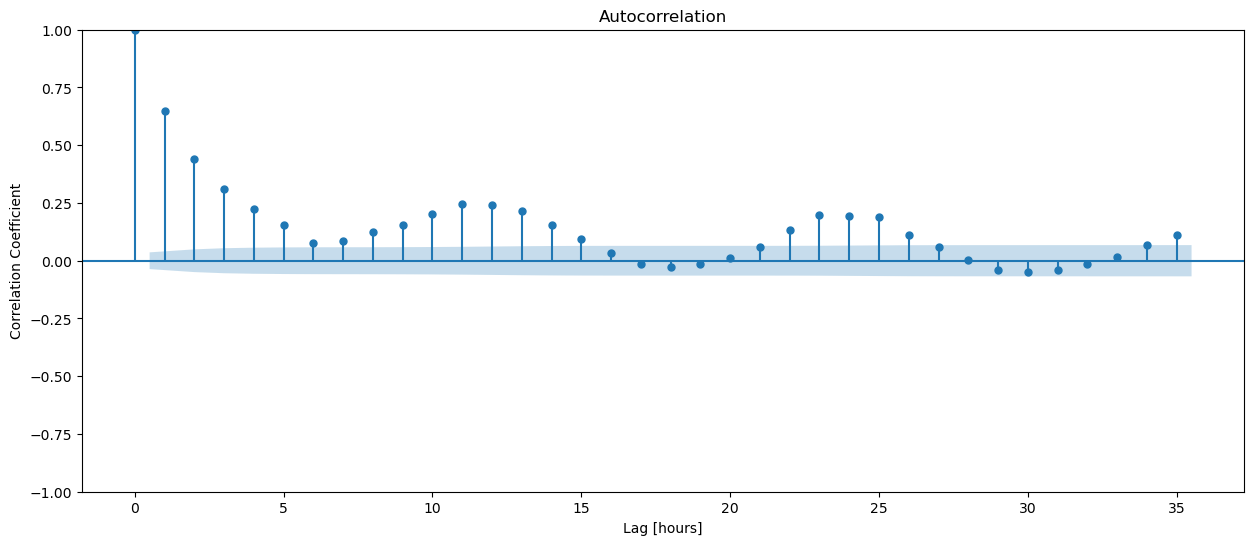

In [97]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

In [98]:
# training and test sets
cutoff_test = round(len(y)*.95)
y_train = y[:cutoff_test]
y_test = y[cutoff_test:]

In [99]:
# Build Model
# Baseline
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 9.21
Baseline MAE: 3.71


In [102]:
# Iterate
model = AutoReg(y_train,lags=26).fit()
y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train[26:],y_pred)
print("Training MAE:", training_mae)

Training MAE: 2.2806831434801667


In [103]:
# the residuals
y_train_resid =model.resid
y_train_resid.tail()

timestamp
2018-12-25 20:00:00+03:00   -1.569997
2018-12-25 21:00:00+03:00   -0.733759
2018-12-25 22:00:00+03:00   -2.022590
2018-12-25 23:00:00+03:00   -0.062134
2018-12-26 00:00:00+03:00   -1.036900
Freq: H, dtype: float64

<Axes: xlabel='timestamp', ylabel='Residual Values'>

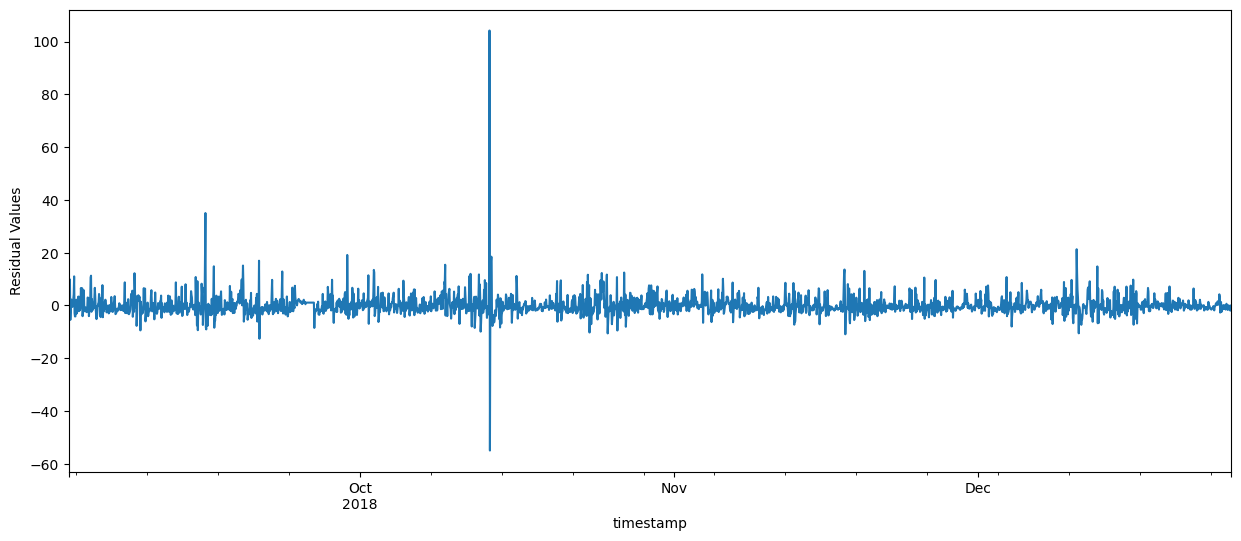

In [104]:
# plot of y_train_resid
fig, ax = plt.subplots(figsize=(15, 6))
y_train_resid.plot(ylabel="Residual Values",ax=ax)

Text(0, 0.5, 'Frequency')

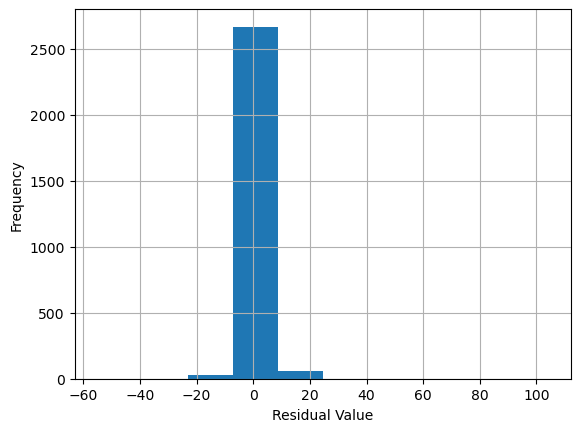

In [106]:
# histogram of y_train_resid
y_train_resid.hist()
plt.xlabel("Residual Value")
plt.ylabel("Frequency")


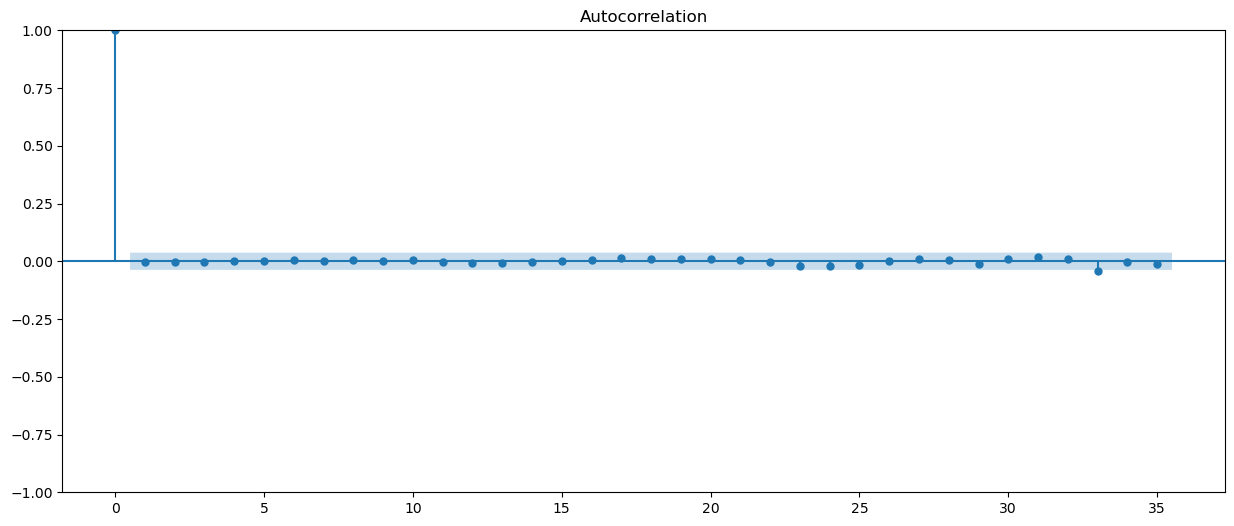

In [107]:
# ACF plot of y_train_resid
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid,ax=ax);

In [108]:
# Evaluate
y_pred_test = model.predict(y_test.index.min(),y_test.index.max())
test_mae = mean_absolute_error(y_test,y_pred_test)
print("Test MAE:", test_mae)

Test MAE: 3.012314137486614


In [109]:
df_pred_test = pd.DataFrame(
    {"y_test": y_test, "y_pred": y_pred_test}, index=y_test.index
)


In [112]:
# line plot for the values in test_predictions
fig = px.line(df_pred_test, labels={"value": "P2"})
fig.show();

In [113]:
%%capture
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model=AutoReg(history,lags=26).fit()
    next_predict=model.forecast()
    y_pred_wfv=y_pred_wfv.append(next_predict)
    history = history.append(y_test[next_predict.index])


In [115]:
# Calculate the mean absolute error for a list of predictions in scikit-learn.
test_mae = mean_absolute_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 1.4


In [116]:
# Communicate Results
# model parameters
print(model.params)

const     2.005712
P2.L1     0.587073
P2.L2     0.019739
P2.L3     0.023495
P2.L4     0.027209
P2.L5     0.044122
P2.L6    -0.102025
P2.L7     0.029361
P2.L8     0.049985
P2.L9    -0.016530
P2.L10    0.032572
P2.L11    0.064378
P2.L12    0.006103
P2.L13    0.018255
P2.L14   -0.007776
P2.L15   -0.015811
P2.L16   -0.016035
P2.L17   -0.035491
P2.L18    0.000678
P2.L19   -0.003858
P2.L20   -0.020509
P2.L21   -0.012504
P2.L22    0.052557
P2.L23    0.074043
P2.L24   -0.023928
P2.L25    0.090695
P2.L26   -0.088098
dtype: float64


In [117]:
# line plot for df_pred_test
df_pred_test=pd.DataFrame(

    {"y_test":y_test,"y_pred_wfv":y_pred_wfv}
)
fig = px.line(df_pred_test,labels={"value=":"PM2.5"})
fig.show()